In [1]:
import numpy as np
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD import GD
import time
import imageio
from utils import *
from torch.quasirandom import SobolEngine
import sobol_seq

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.sincos(Noise, Noise_level)
# objective = f_class.Branin(Noise, Noise_level)
# objective = f_class.Keane(Noise, Noise_level)
# objective = f_class.Rosenbrock_2(Noise, Noise_level)  
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Alpine(Noise, Noise_level)
# objective = f_class.Shubert_2(Noise, Noise_level)
# objective = f_class.Ackley_2(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
objective = f_class.Levy(Noise, Noise_level)
# objective = f_class.quad(Noise, Noise_level)
# objective = f_class.Eggholder(Noise, Noise_level)
# objective = f_class.Rastrigin(Noise, Noise_level, dim=2)


f = objective.func
clean_f = lambda x: f_class.sincos().func(x)
# clean_f = lambda x: f_class.Branin().func(x)
# clean_f = lambda x: f_class.Keane().func(x)
# clean_f = lambda x: f_class.Rosenbrock_2().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
# clean_f = lambda x: f_class.Ackley_2().func(x)  
# clean_f = lambda x: f_class.Schwefel().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
clean_f = lambda x: f_class.Levy().func(x)
# clean_f = lambda x: f_class.quad().func(x) 
# clean_f = lambda x: f_class.Eggholder().func(x)
# clean_f = lambda x: f_class.Rastrigin().func(x)



B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]
# print(f( np.array([1, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[-1.  3.]
 [-1.  3.]]
dim:  2


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=3000)
# del gp
# (ls, var)

##### Sampling

In [6]:
def unique_row(X):
    """
    A functions to trim repeated rows that may appear when optimizing.
    :param X: array to trim repeated rows from
    :return: mask of unique rows
    """
    # Sort array and kep track of where things should go back to
    order = np.lexsort(X.T)
    reorder = np.argsort(order)
    X = X[order]
    diff = np.diff(X, axis=0)
    U = np.ones(len(X), 'bool')
    U[1:] = (diff != 0).any(axis=1)
    return U[reorder]

class close_data():
    def __init__(self, Xc, eps=1):
        self.Xc = Xc
        self.eps = eps
        
    # Iterable
    def __iter__(self):
        return self
    
    # Iterator
    def __next__(self):
        Xn = self.Xc + self.eps*np.random.uniform(-1, 1, self.Xc.shape)
        return Xn
    
def is_new(Xn, Xpast=None):
    if Xpast is None:
        return True
    else:
        return np.array([(i != Xn).any() for i in Xpast]).all()

    
def close_draw(Xc, n_random_draws=4, close=1, Xpast=None):
    # sample from a small 2d box with center given Xc, no repeated points
    X = np.zeros((n_random_draws, dim))
    X[0] = Xc
    counter = 0
    gc = close_data(Xc)
    while True:
        Xn = next(gc)
        if LA.norm(Xn - Xc) > 5e-2 and is_new(Xn, Xpast) == True:
            counter += 1
            X[counter] = Xn
        if counter == n_random_draws-1:
            break
    return X

#### Grid & Plot

In [7]:
# creating meshgrid to plot over entire range
n_Grid = 100
x1 = np.linspace(lb[0], ub[0], n_Grid)
x2 = np.linspace(lb[1], ub[1], n_Grid)

X1, X2 = np.meshgrid(x1, x2)
Grid = np.vstack((X1.flatten(), X2.flatten())).T
Grid.shape

(10000, 2)

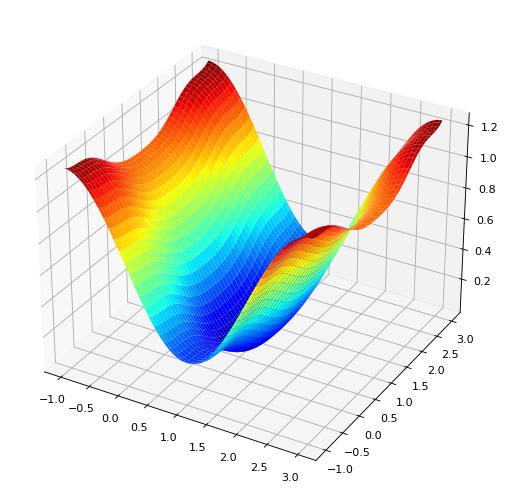

(10000,)

In [8]:
# 3d plot of the test function
from numpy import arange
from numpy import meshgrid
from matplotlib import pyplot
from matplotlib.pyplot import figure
# compute targets
results = f(Grid).reshape(X1.shape)
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, results, cmap='jet')
# show the plot
pyplot.show()
f(Grid).shape

In [9]:
# 3d plot of the gradient
# approximate the gradient
from scipy import optimize

# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
approx_grad.shape
g1 = approx_grad[:, 0]
g2 = approx_grad[:, 1]
g1, g2

(array([-1.49011612e-08, -4.98130322e-02, -9.94254947e-02, ...,
         9.94254649e-02,  4.98130471e-02, -1.49011612e-08]),
 array([-0.25      , -0.24999999, -0.24999999, ...,  0.25000001,
         0.25000001,  0.25      ]))

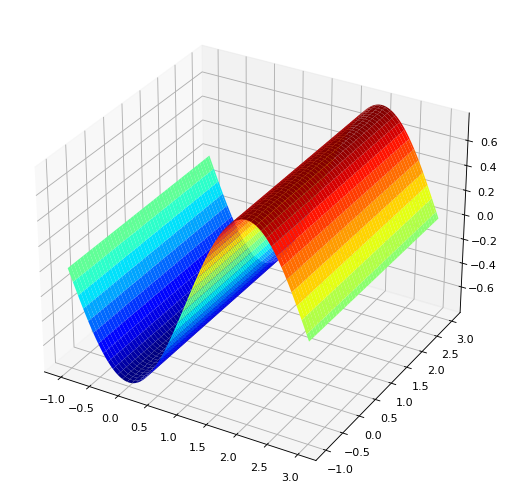

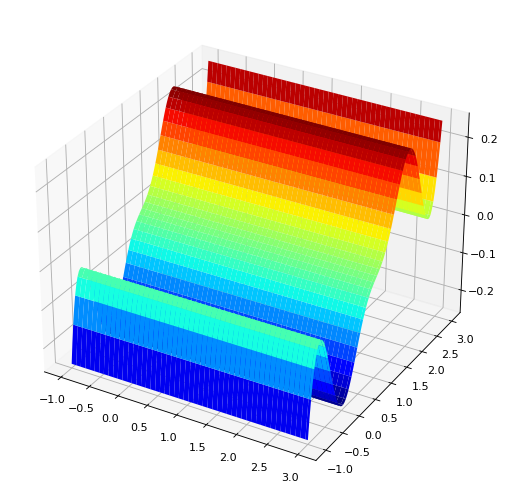

In [10]:
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g1.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g2.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# *BO Test*

In [11]:
MAX = 50 # function observations

## GD

#### Set up

In [12]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
# w = X[np.argmin(f(X))].reshape(1, dim)

# # sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)
# X_fix = X

In [13]:
gp = GP_grad(B, Noise, Noise_level, compress=False)
# gp.set_hyper(ls, var) # if online, skip

gp.set_data(X, f(X))

gp.optimize()
gp.fit()

history = []

##### warm up with UCB

In [14]:
# warmup = 3
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history_warmup.append( (w, f(w)) )
    
# X_fix = X

##### warm up with TS

In [15]:
warmup = 2
history_warmup = []
for i in range(1, warmup+1):
    w = gp.Thompson_sample()    
    X = np.vstack([X, w])
    
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    gp.add_data(w.reshape(1, dim), f(w))
    
    if i % 3 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    history_warmup.append( (w, f(w)) )
    
X_fix = X

1, w:  [1.68560648 0.6455183 ], f(w):  0.2730381926067594, 
2, w:  [0.38808048 0.02310038], f(w):  0.3329452225808046, 


In [16]:
# # fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# x = Grid[:,0]
# y = Grid[:,1]

# # Posterior
# mu, covar = gp.posterior(Grid)
# mu = np.squeeze(mu)
# s = np.sqrt(np.diag(covar))

# fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# # plot function
# im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
# fig.colorbar(im, ax=ax2)

# im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
# im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# # im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

# pl.clabel(im1, inline=True, fontsize=8)

# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax1)

# ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

# ax1.title.set_text("Noisy Ackley via posterior derivative mean")
# ax2.title.set_text("Standard deviation")
# pl.show()

In [17]:
# pl.figure(figsize=(13, 8), dpi=80)
# pl.plot(np.squeeze(np.array(history_warmup)[:, 1]), "-^")
# pl.xlabel("cost")
# pl.ylabel("function value")
# pl.grid(True)

##### optimize with GD

In [18]:
w = gp.X[np.argmin(gp.y)]
optimizer = GD(gp, B, w, f)

In [19]:
gp.posterior(w), f(w)
# gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

((array([[0.27303819]]), array([[9.99999994e-09]])), array([0.27303819]))

In [20]:
optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

array([ 0.69155508, -0.06775558])

In [21]:
gp.optimize()
np.set_printoptions(precision=4)
stall = False
cost = setup + warmup
desc = -optimizer._grad()

lr_const = 0.01
lr = lr_const

# create a candidate list of GD points from all queried points so far
optimizerHouse = [GD(gp, B, w, f) for w in gp.X]
while cost <= MAX:
    print(cost, end = '. ')
    # maintain best val so far
    y_best = np.min(f(gp.X))
    delta = np.abs(1e-2 * y_best)
    
    maxPI = 0
#     minEI = 0
    for i in range(len(optimizerHouse)):
        # if optimizer fail > stop loop, never pick that local GD
        if optimizerHouse[i].contFail <= optimizerHouse[i].stop:
            w, desc = optimizerHouse[i].update_sample(y_best=y_best - delta, lr=lr)
#             # EI
#             if gp.EI(w, y_best) < minEI and cost > 20:
#                 minEI = gp.EI(w, y_best)
#                 bestW = w
#                 bestIndex = i
            # PI
            if gp.PI(w, y_best) > maxPI:
                maxPI = gp.PI(w, y_best)
                bestW = w
                bestIndex = i
                
    if np.random.uniform(0, 1, 1).item() < maxPI and cost > 10:
        print('GD suggests with Pr = ', maxPI)
        print('   GD (i, loop) ', (bestIndex, len(optimizerHouse[bestIndex].history_full_w) ))
        w = bestW
#     if np.abs(minEI) > delta:
#         print('GD suggests with EI = ', minEI)
#         print('   GD (i, loop) ', (bestIndex, len(optimizerHouse[bestIndex].history_full_w) ))
#         w = bestW
    else:
        # UCB draw
        b = np.log(cost**gp.dim)
#         b = cost**gp.dim
        w, _ = gp.ucb_minimize(b)
#         w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
        print('UCB suggests with (1 - Pr) = ', 1 - maxPI)
#         print('UCB suggests with EI = ', minEI)
        
        optimizerHouse.append(GD(gp, B, w, f))
        print('   UCB create new index ', len(optimizerHouse) - 1)
    
    if is_new(w, gp.X) == False:
        raise ValueError('  ? hit past points')
    
    
    gp.add_data(w.reshape(1, -1), f(w))
    cost += 1
        
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    
    history.append( (w, f(w)) )
    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.4f ' % f(w).item())
    print('     d(w): ', np.squeeze(m), end = ', ')
    print('    s.d: ', np.squeeze(v), end = ', ')
    print('    g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print('    y best:', y_best)
    print()
        
    
print('Max Cost reached = ', cost)
# history.append(optimizer.history_w)
# history_f.append([f(w).item() for w in optimizer.history_w])

3. UCB suggests with (1 - Pr) =  0.49352281629267414
   UCB create new index  3
    w:  [0.9136 2.876 ],     f(w): 0.2328 
     d(w):  [ 6.8899e-35 -5.9795e-35],     s.d:  [3.5115 3.5115],     g(w): [-0.1063  0.1121]
    y best: 0.2730381926067594

4. UCB suggests with (1 - Pr) =  0.4944773365346381
   UCB create new index  4
    w:  [-0.9526  1.8495],     f(w): 1.0863 
     d(w):  [1.3105e-40 7.2081e-41],     s.d:  [3.5115 3.5115],     g(w): [-0.0584  0.2388]
    y best: 0.23279870239583175

5. UCB suggests with (1 - Pr) =  0.4907382724306454
   UCB create new index  5
  # Optimal (ls, var) =  (1.0, 0.5950811562511443)
    w:  [ 2.9288 -0.9547],     f(w): 1.2369 
     d(w):  [ 0.047  -0.0111],     s.d:  [0.7594 0.7533],     g(w): [ 0.0877 -0.1924]
    y best: 0.23279870239583175

6. UCB suggests with (1 - Pr) =  0.4671760072601151
   UCB create new index  6
    w:  [-1. -1.],     f(w): 1.2500 
     d(w):  [0.0139 0.0613],     s.d:  [0.7244 0.7458],     g(w): [-1.4901e-08 -2.5000e-01]


37. UCB suggests with (1 - Pr) =  0.9851975800647407
   UCB create new index  15
    w:  [ 1.1491 -0.1027],     f(w): 0.1637 
     d(w):  [ 0.1617 -0.1797],     s.d:  [0.1854 0.1465],     g(w): [ 0.1822 -0.2343]
    y best: 0.008431092487893225

38. UCB suggests with (1 - Pr) =  0.9987713622667322
   UCB create new index  16
  # Optimal (ls, var) =  (1.0, 0.3481963777080927)
    w:  [1.2574 2.2315],     f(w): 0.2179 
     d(w):  [0.3818 0.2005],     s.d:  [0.1087 0.0683],     g(w): [0.309  0.1894]
    y best: 0.008431092487893225

39. UCB suggests with (1 - Pr) =  0.9999281590864129
   UCB create new index  17
    w:  [0.9352 0.5995],     f(w): 0.0161 
     d(w):  [-0.0572 -0.0845],     s.d:  [0.0744 0.0271],     g(w): [-0.0798 -0.0824]
    y best: 0.008431092487893225

40. UCB suggests with (1 - Pr) =  0.9999702201034789
   UCB create new index  18
    w:  [1.0845 0.7975],     f(w): 0.0072 
     d(w):  [ 0.1054 -0.0374],     s.d:  [0.0228 0.0116],     g(w): [ 0.104  -0.0302]
    y bes

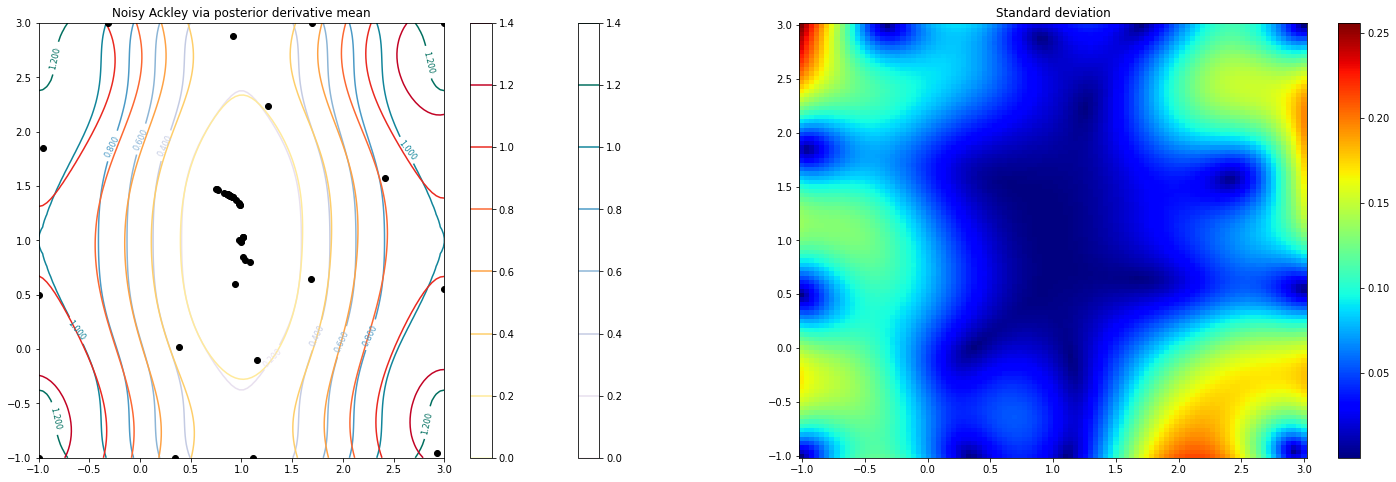

In [22]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")
pl.show()

<ipython-input-23-0b3d1842ec4f>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
<ipython-input-23-0b3d1842ec4f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'g', lw=2)


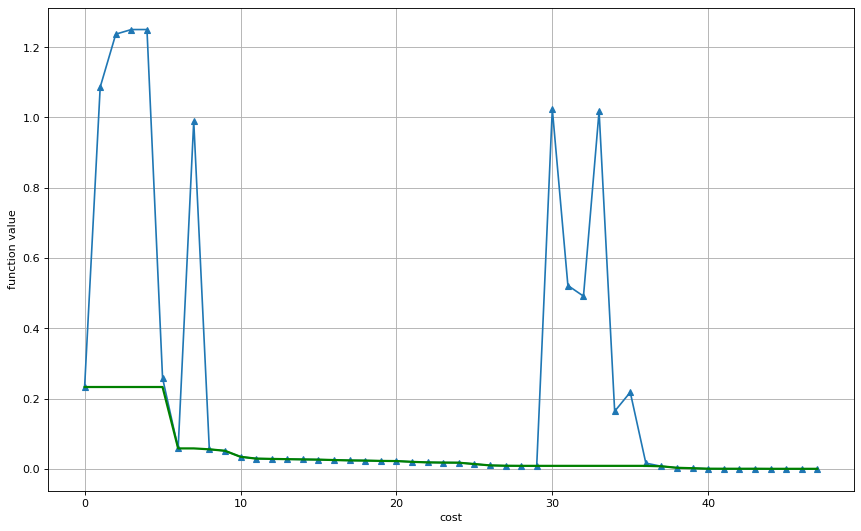

In [23]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'g', lw=2)
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [24]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([0.9981, 0.9985]), 2.3605862316527473e-06, 48)

In [25]:
gp.get_hyper()

{'var': 0.32181175034238446, 'lengthscale': 1.0}

In [26]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *UCB*

In [27]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_ucb = []

In [28]:
cost = setup + warmup
while cost < MAX:
    # 1. Thompson Sampling
#     w = gp.Thompson_sample(n_mesh=5000)

    # 2. GP_UCB/EI
    b = np.log(cost**gp.dim)
#     b = cost**gp.dim
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
    w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    history_ucb.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

3, w:  [-1.  3.], f(w):  1.25, 
  # Optimal (ls, var) =  (1.0, 0.610447559277522)
4, w:  [ 3. -1.], f(w):  1.25, 
5, w:  [-1. -1.], f(w):  1.25, 
6, w:  [1.2179 3.    ], f(w):  0.2789957964209109, 
  # Optimal (ls, var) =  (1.0, 0.7762895805091959)
7, w:  [0.3069 1.4544], f(w):  0.28662202534665643, 
8, w:  [3. 3.], f(w):  1.25, 
9, w:  [-1.      0.9439], f(w):  1.0001979079822674, 
  # Optimal (ls, var) =  (1.0, 0.6966319615960853)
10, w:  [ 1.1572 -1.    ], f(w):  0.2651733056286343, 
11, w:  [3.     0.5329], f(w):  1.0197464384007906, 
12, w:  [1.1914 1.8093], f(w):  0.10072652408086216, 
  # Optimal (ls, var) =  (1.0, 0.5536786530420891)
13, w:  [0.4429 2.6354], f(w):  0.3957985998880227, 
14, w:  [0.9256 0.8433], f(w):  0.005033804143012646, 
15, w:  [ 1.2414 -0.1044], f(w):  0.18593816239092875, 
  # Optimal (ls, var) =  (1.0, 0.450519556175995)
16, w:  [ 0.4364 -1.    ], f(w):  0.4334459258641833, 
17, w:  [1.1112 1.2634], f(w):  0.012650156137047758, 
18, w:  [0.8281 1.6589], f

<ipython-input-29-c7097c567240>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^")
<ipython-input-29-c7097c567240>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)


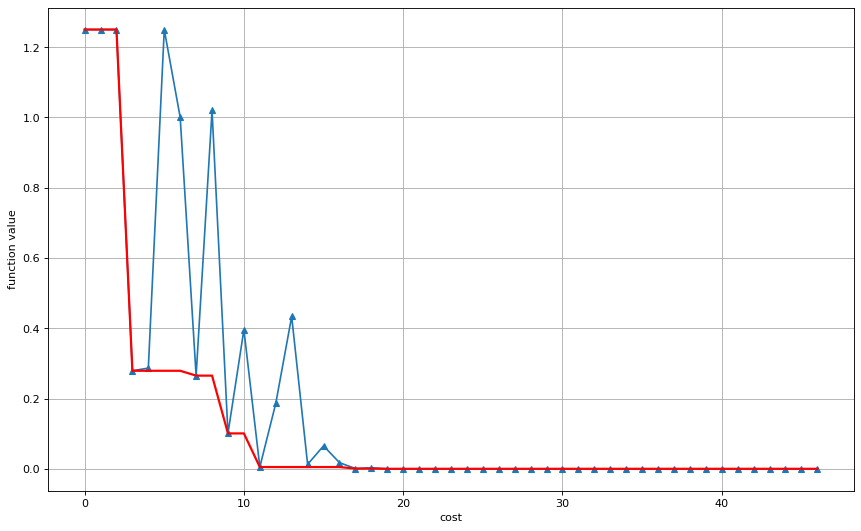

In [29]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^")
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)
pl.ylabel("function value")
pl.grid(True)

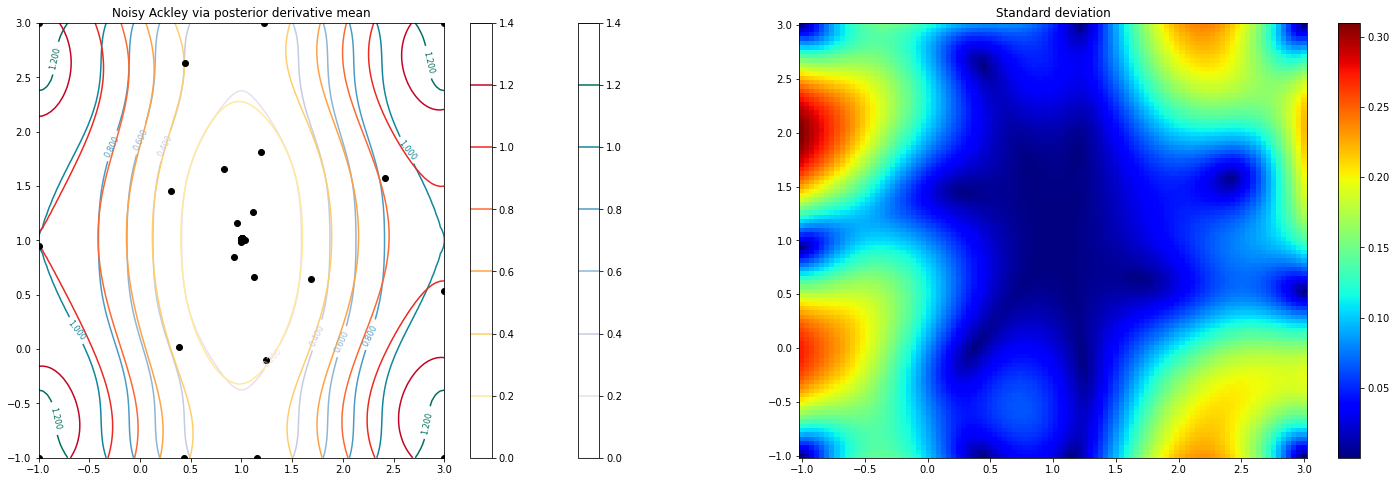

In [30]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")
pl.show()

## Global Minima 

In [31]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([1.0003, 0.9958]), 1.17602305350737e-06, 47)

In [32]:
gp.get_hyper()

{'var': 0.34971381524744244, 'lengthscale': 1.0}

### EI

In [33]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_EI = []

In [34]:
cost = setup + warmup
while cost < MAX:
    # 1. Thompson Sampling
#     w = gp.Thompson_sample(n_mesh=5000)

    
    # 2. GP_UCB/EI
#     b = np.log(cost**gp.dim)
#     b = cost**gp.dim
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
    w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    
    history_EI.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

3, w:  [-0.5639  0.6055], f(w):  0.9002099850481632, 
  # Optimal (ls, var) =  (1.0, 0.3937749749978792)
4, w:  [ 1.6997 -1.    ], f(w):  0.5228118548564333, 
5, w:  [-1.  3.], f(w):  1.25, 
6, w:  [-1. -1.], f(w):  1.25, 
  # Optimal (ls, var) =  (1.0, 0.6527971629366176)
7, w:  [1.2676 3.    ], f(w):  0.29352348314206805, 
8, w:  [ 3.     -0.3984], f(w):  1.2025109549727209, 
9, w:  [0.8895 1.0364], f(w):  0.007598336674506154, 
  # Optimal (ls, var) =  (0.13806461552909965, 0.6626722058462292)
10, w:  [0.1237 2.4258], f(w):  0.6087427344469897, 
11, w:  [2.7336 2.8594], f(w):  1.1832992165394034, 
12, w:  [-0.9211  1.7699], f(w):  1.0656229797248569, 
  # Optimal (ls, var) =  (1.0, 0.5070162295754072)
13, w:  [1.0803 1.7795], f(w):  0.07554920514625212, 
14, w:  [ 0.7187 -1.    ], f(w):  0.298020799954359, 
15, w:  [1.062  0.2706], f(w):  0.06321265803282358, 
  # Optimal (ls, var) =  (1.0, 0.41394460637464026)
16, w:  [1.1308 1.0141], f(w):  0.01053631524667139, 
17, w:  [0.9885 0.

<ipython-input-35-e6d3482b447c>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history_EI)[:, 1]), "-^")
<ipython-input-35-e6d3482b447c>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history_EI)[:, 1]), 'b', lw=2)


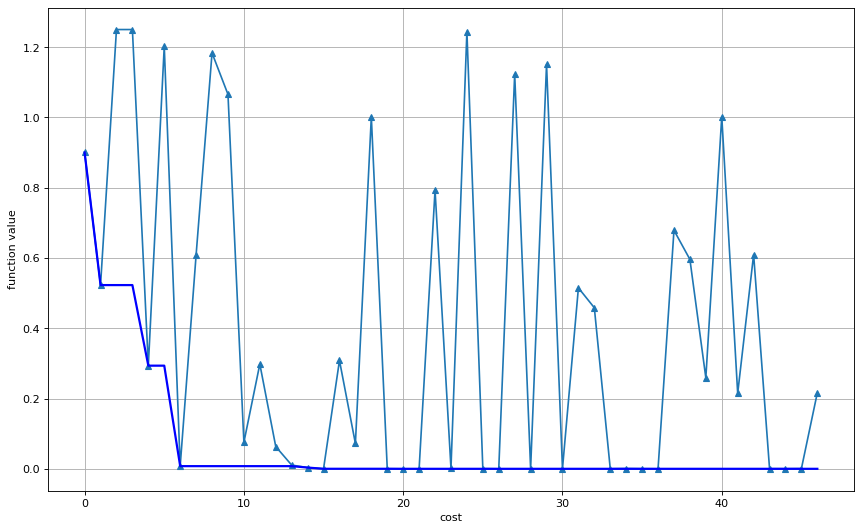

In [35]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history_EI)[:, 1]), "-^")
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history_EI)[:, 1]), 'b', lw=2)
pl.ylabel("function value")
pl.grid(True)

In [36]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([0.9998, 1.    ]), 3.404901536660162e-08, 39)

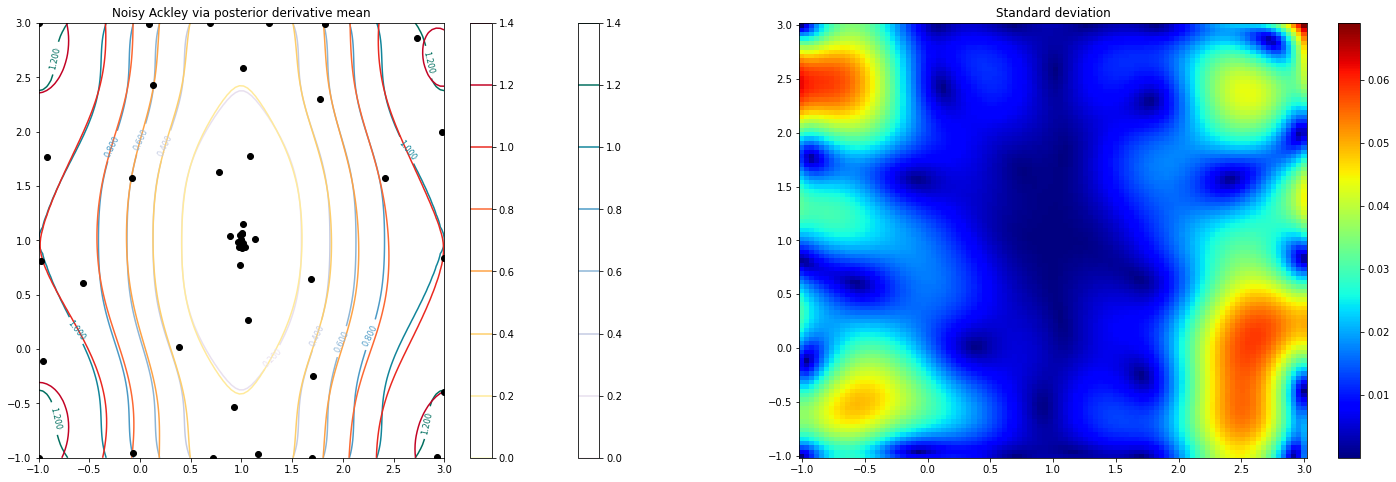

In [37]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")
# im2 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

ax1.plot(np.squeeze(gp.X[:, 0]), np.squeeze(gp.X[:, 1]), 'ko', linewidth=2)

ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")
pl.show()

# Comparison

<ipython-input-38-a9f3db991b8f>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2, label='UCB')
<ipython-input-38-a9f3db991b8f>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history_EI)[:, 1]), 'b', lw=2, label='EI')
<ipython-input-38-a9f3db991b8f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant 

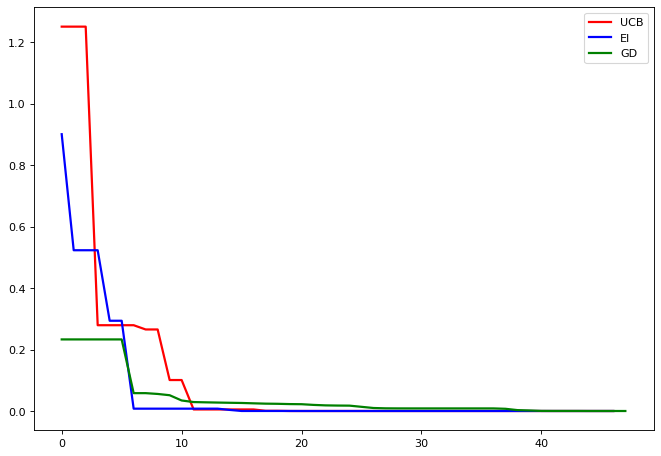

In [38]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2, label='UCB')
pl.plot(np.minimum.accumulate(np.array(history_EI)[:, 1]), 'b', lw=2, label='EI')
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'g', lw=2, label='GD')
# pl.ylim([0, 30])
# pl.xlim([0, MAX])
pl.legend()